# Korean Easy Data Augmentation

* Code from https://github.com/catSirup/KorEDA.git

In [1]:
import pandas as pd
import numpy as np
import random
random.seed(42)

train_data = pd.read_csv('../../dataset/train/train.csv')
test_data = pd.read_csv('../../dataset/test/test_data.csv')

In [2]:
train_data

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia
...,...,...,...,...,...,...
32465,32465,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등...,"{'word': '유기준', 'start_idx': 93, 'end_idx': 95...","{'word': '부산 서구·동구', 'start_idx': 100, 'end_id...",per:employee_of,wikitree
32466,32466,"법포는 다시 최시형, 서병학, 손병희 직계인 북접과 다시 서장옥, 전봉준, 김개남을...","{'word': '최시형', 'start_idx': 7, 'end_idx': 9, ...","{'word': '손병희', 'start_idx': 17, 'end_idx': 19...",per:colleagues,wikipedia
32467,32467,완도군(군수 신우철)이 국토교통부에서 실시한 '2019 교통문화지수 실태조사'에서 ...,"{'word': '완도군', 'start_idx': 0, 'end_idx': 2, ...","{'word': '신우철', 'start_idx': 7, 'end_idx': 9, ...",org:top_members/employees,wikitree
32468,32468,"중앙일보, JTBC 회장을 지낸 이후 중앙홀딩스 회장, 재단법인 한반도평화만들기 이...","{'word': 'JTBC', 'start_idx': 6, 'end_idx': 9,...","{'word': '중앙홀딩스', 'start_idx': 21, 'end_idx': ...",no_relation,wikipedia


## Synonym Replacement (SR)

### WordNet 편집

In [3]:
import pickle
import re

wordnet = {}
with open("wordnet.pickle", "rb") as f:
    wordnet = pickle.load(f)


# 한글만 남기고 나머지는 삭제
def get_only_hangul(line):
    parseText= re.compile('/ ^[ㄱ-ㅎㅏ-ㅣ가-힣]*$/').sub('',line)

    return parseText

In [4]:
print(wordnet['리그'])
print(wordnet['정치'])

['리그', '동맹', '연합', '연맹', '조정']
['정치']


In [5]:
# wordnet 유사어 집합 내 타겟과 동일한 단어 제거
useless_keys = []
for key, values in wordnet.items():
    if wordnet[key] == [key]:
        useless_keys.append(key)
    if key in values:
        values.remove(key)

for uk in useless_keys:
    del wordnet[uk]

In [6]:
print(wordnet['리그'])
try:
    print(wordnet['정치']) # 에러 발생하면 제대로 지워진 것
except:
    print('해당 wordnet은 삭제되었습니다.')

['동맹', '연합', '연맹', '조정']
해당 wordnet은 삭제되었습니다.


In [21]:
from konlpy.tag import *
from collections import defaultdict


def synonym_replacement(data, n=2):
    random.seed(42)
    replaced_dict = defaultdict(list)
    for idx, d in data.iterrows():
        sentence = d.sentence
        replaced_sentence = sentence
        sbj_dict, obj_dict = eval(d.subject_entity), eval(d.object_entity)
        
        # 형태소 단위로 분리하여 유의어 탐색
        okt = Okt()
        words = [ss for ss in okt.morphs(sentence) if len(ss) > 1] # 1글자 유의어는 틀릴 확률이 너무 높기 때문에, 2글자 이상 단어만
        random_words = list(set([word for word in words]))
        for random_word in random_words:
            if random_word in sbj_dict['word'] or sbj_dict['word'] in random_word or random_word in obj_dict['word'] or obj_dict['word'] in random_word:
                random_words.remove(random_word)
        random.shuffle(random_words)
        
        # 형태소 단위 단어 중 최대 n개의 단어를 유의어로 교체
        num_replaced= 0
        replaced_indices = []
        original_words, replaced_words = [], []
        len_changes = []
        for random_word in random_words:
            synonyms = get_synonyms(random_word)
            if synonyms:
                replaced_index = replaced_sentence.find(random_word)
                replaced_indices.append(replaced_index)

                synonym = random.choice(list(synonyms))
                original_words.append(random_word)
                replaced_words.append(synonym)
                len_changes.append(len(synonym) - len(random_word))
                replaced_sentence = replaced_sentence.replace(random_word, synonym, 1) # 중복 단어인 경우 1개만 변경. 몇 번째 단어를 바꿀지도 정할 수 있으면 좋음(나중에).
                
                num_replaced += 1
                    
            if num_replaced == n:
                break
        
        # 교체된 단어의 길이가 다른 경우, subject_entity와 object_entity의 index가 바뀌었으면 변경하여 저장
        for replaced_index, len_change in zip(replaced_indices, len_changes):
            if replaced_index < sbj_dict['start_idx']:
                if replaced_index < obj_dict['start_idx']:
                    sbj_dict['start_idx'] = sbj_dict['start_idx'] + len_change
                    sbj_dict['end_idx'] = sbj_dict['end_idx'] + len_change
                    obj_dict['start_idx'] = obj_dict['start_idx'] + len_change
                    obj_dict['end_idx'] = obj_dict['end_idx'] + len_change
                else:
                    sbj_dict['start_idx'] = sbj_dict['start_idx'] + len_change
                    sbj_dict['end_idx'] = sbj_dict['end_idx'] + len_change
            else:
                if replaced_index < obj_dict['start_idx']:
                    obj_dict['start_idx'] = obj_dict['start_idx'] + len_change
                    obj_dict['end_idx'] = obj_dict['end_idx'] + len_change
        
        # 증강된 데이터 저장을 위해 dict 형태로 제작
        if sentence != replaced_sentence:
            replaced_dict['sentence'].append(replaced_sentence)
            replaced_dict['id'].append(100000 + d.id) # 증강되어 추가된 데이터의 id는 기존 id + 100000 (SR)
            replaced_dict['subject_entity'].append(str(sbj_dict))
            replaced_dict['object_entity'].append(str(obj_dict))
            replaced_dict['label'].append(d.label)
            replaced_dict['source'].append(d.source)
            replaced_dict['original'].append(original_words)
            replaced_dict['replaced'].append(replaced_words)
            
        # if idx == 9: # early stop for test
        #     break
        
        if (idx + 1) % 1000 == 0:
            print(f'{idx + 1} data are preprocessed.')
            
    print('All data are preprocessed.')
            
    replaced_data = pd.DataFrame.from_dict(replaced_dict)
    augmented_data = pd.concat([data, replaced_data], axis=0, ignore_index=True)

    return augmented_data


def get_synonyms(word):
    synonyms = []
    try:
        for syn in wordnet[word]:
            synonyms.append(syn)
    except:
        pass

    return synonyms

In [22]:
replaced_data = synonym_replacement(train_data, n=2)

In [23]:
replaced_data.to_csv('../../dataset/train/train_aug_sr_2_ksh.csv', index=False)

In [24]:
replaced_data.iloc[32470:]

,id,sentence,subject_entity,object_entity,label,source,original,replaced
32470,100002,K조정2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree,"[리그, 유치]","[조정, 장악]"
32471,100003,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree,[박스],[갑]
32472,100004,1967년 프로그램 구기 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는...,"{'word': '요미우리 자이언츠', 'start_idx': 24, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia,"[야구, 프로]","[구기, 프로그램]"
32473,100005,": 유엔, 유럽 입법부, 북대서양 조약 기구 (NATO), 국제이주기구, 세계 보건...","{'word': '북대서양 조약 기구', 'start_idx': 14, 'end_i...","{'word': 'NATO', 'start_idx': 26, 'end_idx': 2...",org:alternate_names,wikipedia,"[의회, 연합]","[입법부, 동맹]"
32474,100006,그에 따라 나폴리와 임대차을 날개한 마라도나는 1989년 팀을 UEFA컵 정상으로 ...,"{'word': 'AC 밀란', 'start_idx': 65, 'end_idx': ...","{'word': '1989', 'start_idx': 26, 'end_idx': 2...",no_relation,wikipedia,"[연장, 계약]","[날개, 임대차]"
...,...,...,...,...,...,...,...,...
56374,132464,KIA타이거즈 외야수 이창진이 롯데슈퍼 광주점이 시상하는 9월 월간 MVP에 선정돼...,"{'word': '이창진', 'start_idx': 12, 'end_idx': 14...","{'word': '외야수', 'start_idx': 8, 'end_idx': 10,...",per:title,wikitree,[백화점],[슈퍼]
56375,132465,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위시설 후보자 등...,"{'word': '유기준', 'start_idx': 93, 'end_idx': 95...","{'word': '부산 서구·동구', 'start_idx': 100, 'end_id...",per:employee_of,wikitree,"[대전, 의장]","[왕궁, 시설]"
56376,132467,완도군(군수 신우철)이 국토이동부에서 실시한 '2019 교통문화지수 실태조사'에서 ...,"{'word': '완도군', 'start_idx': 0, 'end_idx': 2, ...","{'word': '신우철', 'start_idx': 7, 'end_idx': 9, ...",org:top_members/employees,wikitree,"[등급, 교통]","[정도, 이동]"
56377,132468,"중앙일보, JTBC 총재을 지낸 이후 중앙홀딩스 회장, 재단법인 한반도평화만들기 이...","{'word': 'JTBC', 'start_idx': 6, 'end_idx': 9,...","{'word': '중앙홀딩스', 'start_idx': 21, 'end_idx': ...",no_relation,wikipedia,[회장],[총재]


In [25]:
print(replaced_data.sentence.iloc[5])
print(replaced_data.sentence.iloc[32473])
print(replaced_data.subject_entity.iloc[5], replaced_data.object_entity.iloc[5])
print(replaced_data.subject_entity.iloc[32473], replaced_data.object_entity.iloc[32473])

: 유엔, 유럽 의회, 북대서양 조약 기구 (NATO), 국제이주기구, 세계 보건 기구 (WHO), 지중해 연합, 이슬람 협력 기구, 유럽 안보 협력 기구, 국제 통화 기금, 세계무역기구 그리고 프랑코포니.
: 유엔, 유럽 입법부, 북대서양 조약 기구 (NATO), 국제이주기구, 세계 보건 기구 (WHO), 지중해 동맹, 이슬람 협력 기구, 유럽 안보 협력 기구, 국제 통화 기금, 세계무역기구 그리고 프랑코포니.
{'word': '북대서양 조약 기구', 'start_idx': 13, 'end_idx': 22, 'type': 'ORG'} {'word': 'NATO', 'start_idx': 25, 'end_idx': 28, 'type': 'ORG'}
{'word': '북대서양 조약 기구', 'start_idx': 14, 'end_idx': 23, 'type': 'ORG'} {'word': 'NATO', 'start_idx': 26, 'end_idx': 29, 'type': 'ORG'}


In [26]:
print(replaced_data.sentence.iloc[6])
print(replaced_data.sentence.iloc[32474])
print(replaced_data.subject_entity.iloc[6], replaced_data.object_entity.iloc[6])
print(replaced_data.subject_entity.iloc[32474], replaced_data.object_entity.iloc[32474])

그에 따라 나폴리와 계약을 연장한 마라도나는 1989년 팀을 UEFA컵 정상으로 인도했으며 이듬해에는 유럽 챔피언 AC 밀란을 상대로 승리를 거두고 다시 한 번 세리에A에서 정상에 등극했다.
그에 따라 나폴리와 임대차을 날개한 마라도나는 1989년 팀을 UEFA컵 정상으로 인도했으며 이듬해에는 유럽 챔피언 AC 밀란을 상대로 승리를 거두고 다시 한 번 세리에A에서 정상에 등극했다.
{'word': 'AC 밀란', 'start_idx': 64, 'end_idx': 68, 'type': 'ORG'} {'word': '1989', 'start_idx': 25, 'end_idx': 28, 'type': 'DAT'}
{'word': 'AC 밀란', 'start_idx': 65, 'end_idx': 69, 'type': 'ORG'} {'word': '1989', 'start_idx': 26, 'end_idx': 29, 'type': 'DAT'}


In [30]:
print("# of Original Data:", len(train_data)) # 기존 데이터 개수
print("# of Augmented Data Only", len(replaced_data[len(train_data):])) # 증강 데이터 개수만
print("# of Total Data (Original + Augmented):", len(replaced_data)) # 증강된 총 데이터 개수

# of Original Data: 32470
# of Augmented Data Only 23909
# of Total Data (Original + Augmented): 56379


## Random Deletion (RD)

In [77]:
from konlpy.tag import Okt
from collections import defaultdict
import re


def random_deletion(data, n=1):
    random.seed(42)
    replaced_dict = defaultdict(list)
    for idx, d in data.iterrows():
        sentence = d.sentence
        replaced_sentence = sentence
        sbj_dict, obj_dict = eval(d.subject_entity), eval(d.object_entity)
        
        # 형태소 단위로 분리
        okt = Okt()
        words = [ss for ss in okt.morphs(sentence) if len(ss) > 1] # 2글자 이상 단어만
        random_words = list(set([word for word in words]))
        for random_word in random_words:
            if random_word in sbj_dict['word'] or sbj_dict['word'] in random_word or random_word in obj_dict['word'] or obj_dict['word'] in random_word:
                random_words.remove(random_word)
        random.shuffle(random_words)
        
        # 단어 랜덤 삭제
        num_replaced = 0
        replaced_indices = []
        original_words, replaced_words = [], []
        len_changes = []
        for random_word in random_words:
            match = re.search(r"[(){}\[\]<>]", random_word)
            if match:
                continue
            replaced_index = replaced_sentence.find(random_word)
            replaced_indices.append(replaced_index)

            original_words.append(random_word)
            replaced_words.append('')
            replaced_sentence = replaced_sentence.replace(random_word, '', 1) # 중복 단어인 경우 1개만 삭제
            if '  ' in replaced_sentence:
                replaced_sentence = replaced_sentence.replace('  ', ' ') # 단어 삭제로 인한 이중 띄어쓰기 삭제
                len_changes.append(-1 * (len(random_word) + 1))
            else:
                len_changes.append(-1 * len(random_word))
            num_replaced += 1
            
            if num_replaced == n:
                break
            
        # subject_entity와 object_entity의 index가 바뀌었으면 변경하여 저장
        for replaced_index, len_change in zip(replaced_indices, len_changes):
            if replaced_index < sbj_dict['start_idx']:
                if replaced_index < obj_dict['start_idx']:
                    sbj_dict['start_idx'] = sbj_dict['start_idx'] + len_change
                    sbj_dict['end_idx'] = sbj_dict['end_idx'] + len_change
                    obj_dict['start_idx'] = obj_dict['start_idx'] + len_change
                    obj_dict['end_idx'] = obj_dict['end_idx'] + len_change
                else:
                    sbj_dict['start_idx'] = sbj_dict['start_idx'] + len_change
                    sbj_dict['end_idx'] = sbj_dict['end_idx'] + len_change
            else:
                if replaced_index < obj_dict['start_idx']:
                    obj_dict['start_idx'] = obj_dict['start_idx'] + len_change
                    obj_dict['end_idx'] = obj_dict['end_idx'] + len_change
                    
        # 증강된 데이터 저장을 위해 dict 형태로 제작
        if sentence != replaced_sentence:
            replaced_dict['sentence'].append(replaced_sentence)
            replaced_dict['id'].append(200000 + d.id) # 증강되어 추가된 데이터의 id는 기존 id + 200000 (RD)
            replaced_dict['subject_entity'].append(str(sbj_dict))
            replaced_dict['object_entity'].append(str(obj_dict))
            replaced_dict['label'].append(d.label)
            replaced_dict['source'].append(d.source)
            replaced_dict['original'].append(original_words)
            replaced_dict['replaced'].append(replaced_words)

        # if idx == 9: # early stop for test
        #     break

        if (idx + 1) % 1000 == 0:
            print(f'{idx + 1} data are preprocessed.')
            
    print('All data are preprocessed.')
            
    replaced_data = pd.DataFrame.from_dict(replaced_dict)
    augmented_data = pd.concat([data, replaced_data], axis=0, ignore_index=True)

    return augmented_data

In [78]:
deleted_data = random_deletion(train_data, n=1)

1000 data are preprocessed.
2000 data are preprocessed.
3000 data are preprocessed.
4000 data are preprocessed.
5000 data are preprocessed.
6000 data are preprocessed.
7000 data are preprocessed.
8000 data are preprocessed.
9000 data are preprocessed.
10000 data are preprocessed.
11000 data are preprocessed.
12000 data are preprocessed.
13000 data are preprocessed.
14000 data are preprocessed.
15000 data are preprocessed.
16000 data are preprocessed.
17000 data are preprocessed.
18000 data are preprocessed.
19000 data are preprocessed.
20000 data are preprocessed.
21000 data are preprocessed.
22000 data are preprocessed.
23000 data are preprocessed.
24000 data are preprocessed.
25000 data are preprocessed.
26000 data are preprocessed.
27000 data are preprocessed.
28000 data are preprocessed.
29000 data are preprocessed.
30000 data are preprocessed.
31000 data are preprocessed.
32000 data are preprocessed.
All data are preprocessed.


In [79]:
deleted_data.to_csv('~/dataset/train/train_aug_rd_1_ksh.csv', index=False)

In [80]:
deleted_data.iloc[32470:]

,id,sentence,subject_entity,object_entity,label,source,original,replaced
32470,200000,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia,[담은],[]
32471,200001,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree,[재탄생],[]
32472,200002,K리그2에서 성적 1위를 고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터 관...,"{'word': '광주FC', 'start_idx': 19, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 32, 'end_idx...",org:member_of,wikitree,[달리],[]
32473,200003,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree,[밝혔다],[]
32474,200004,1967년 프로 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8번으로...,"{'word': '요미우리 자이언츠', 'start_idx': 19, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia,[야구],[]
...,...,...,...,...,...,...,...,...
64935,232465,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등...,"{'word': '유기준', 'start_idx': 93, 'end_idx': 95...","{'word': '부산 서구·동구', 'start_idx': 100, 'end_id...",per:employee_of,wikitree,[안양시],[]
64936,232466,"법포는 다시 최시형, 서병학, 손병희 직계인 북접과 다시 서장옥, 전봉준, 김개남을...","{'word': '최시형', 'start_idx': 7, 'end_idx': 9, ...","{'word': '손병희', 'start_idx': 17, 'end_idx': 19...",per:colleagues,wikipedia,[나뉘게],[]
64937,232467,완도군(군수 신우철)이 국토교통부에서 한 '2019 교통문화지수 실태조사'에서 22...,"{'word': '완도군', 'start_idx': 0, 'end_idx': 2, ...","{'word': '신우철', 'start_idx': 7, 'end_idx': 9, ...",org:top_members/employees,wikitree,[실시],[]
64938,232468,"중앙일보, JTBC 회장을 지낸 이후 중앙홀딩스 회장, 재단법인 한반도평화 이사장,...","{'word': 'JTBC', 'start_idx': 6, 'end_idx': 9,...","{'word': '중앙홀딩스', 'start_idx': 21, 'end_idx': ...",no_relation,wikipedia,[만들기],[]


In [81]:
print(deleted_data.sentence.iloc[9])
print(deleted_data.sentence.iloc[32479])
print(deleted_data.subject_entity.iloc[9], deleted_data.object_entity.iloc[9])
print(deleted_data.subject_entity.iloc[32479], deleted_data.object_entity.iloc[32479])

특히 김동연 전 경제부총리를 비롯한 김두관 국회의원, 안규백 국회의원, 김종민 국회의원, 오제세 국회의원, 최운열 국회의원, 김정우 국회의원, 권칠승 국회의원, 맹성규 국회의원등 더불어민주당 국회의원 8명이 영상 축하 메세지를 보내 눈길을 끌었다.
특히 김동연 전 경제부총리를 비롯한 국회의원, 안규백 국회의원, 김종민 국회의원, 오제세 국회의원, 최운열 국회의원, 김정우 국회의원, 권칠승 국회의원, 맹성규 국회의원등 더불어민주당 국회의원 8명이 영상 축하 메세지를 보내 눈길을 끌었다.
{'word': '안규백', 'start_idx': 30, 'end_idx': 32, 'type': 'PER'} {'word': '더불어민주당', 'start_idx': 100, 'end_idx': 105, 'type': 'ORG'}
{'word': '안규백', 'start_idx': 26, 'end_idx': 28, 'type': 'PER'} {'word': '더불어민주당', 'start_idx': 96, 'end_idx': 101, 'type': 'ORG'}


## Random Swap (RS)

In [50]:
from konlpy.tag import Okt
from collections import defaultdict
import re


def random_swap(data, n_pairs=1):
    random.seed(42)
    replaced_dict = defaultdict(list)
    for idx, d in data.iterrows():
        sentence = d.sentence
        replaced_sentence = sentence
        sbj_dict, obj_dict = eval(d.subject_entity), eval(d.object_entity)
        
        # 형태소 단위로 분리
        okt = Okt()
        words = [ss for ss in okt.nouns(sentence) if len(ss) > 1] # 2글자 이상 '명사' 단어만
        random_words = list(set([word for word in words]))
        for random_word in random_words:
            if random_word in sbj_dict['word'] or sbj_dict['word'] in random_word or random_word in obj_dict['word'] or obj_dict['word'] in random_word:
                random_words.remove(random_word)
        random.shuffle(random_words)
        
        # 단어 랜덤 스왑
        num_replaced = 0
        replaced_indices = []
        original_words, replaced_words = [], []
        len_changes = []
        random_words_pairs = [[random_word1, random_word2] for random_word1, random_word2 in zip(random_words[:-1], random_words[1:])]
        for random_words_pair in random_words_pairs:
            random_word1, random_word2 = random_words_pair[0], random_words_pair[1]
            replaced_index1, replaced_index2 = replaced_sentence.find(random_word1), replaced_sentence.find(random_word2)
            if replaced_index1 > replaced_index2:
                random_word1, random_word2 = random_word2, random_word1
                replaced_index1, replaced_index2 = replaced_index2, replaced_index1
            replaced_indices.extend([replaced_index1, replaced_index2])

            original_words.extend([random_word1, random_word2])
            replaced_words.extend([random_word2, random_word1])
            len_changes.extend([len(random_word2) - len(random_word1), len(random_word1) - len(random_word2)])
            replaced_sentence1 = replaced_sentence.replace(random_word1, random_word2, 1)
            replaced_sentence2 = replaced_sentence.replace(random_word2, random_word1, 1)
            replaced_sentence = replaced_sentence1[:replaced_index1 + len(random_word2) + 1] + replaced_sentence2[replaced_index1 + len(random_word2) + 1:]

            num_replaced += 1
            
            if num_replaced == n_pairs:
                break
            
        # subject_entity와 object_entity의 index가 바뀌었으면 변경하여 저장
        for replaced_index, len_change in zip(replaced_indices, len_changes):
            if replaced_index < sbj_dict['start_idx']:
                if replaced_index < obj_dict['start_idx']:
                    sbj_dict['start_idx'] = sbj_dict['start_idx'] + len_change
                    sbj_dict['end_idx'] = sbj_dict['end_idx'] + len_change
                    obj_dict['start_idx'] = obj_dict['start_idx'] + len_change
                    obj_dict['end_idx'] = obj_dict['end_idx'] + len_change
                else:
                    sbj_dict['start_idx'] = sbj_dict['start_idx'] + len_change
                    sbj_dict['end_idx'] = sbj_dict['end_idx'] + len_change
            else:
                if replaced_index < obj_dict['start_idx']:
                    obj_dict['start_idx'] = obj_dict['start_idx'] + len_change
                    obj_dict['end_idx'] = obj_dict['end_idx'] + len_change
                    
        # 증강된 데이터 저장을 위해 dict 형태로 제작
        if sentence != replaced_sentence:
            replaced_dict['sentence'].append(replaced_sentence)
            replaced_dict['id'].append(300000 + d.id) # 증강되어 추가된 데이터의 id는 기존 id + 300000 (RS)
            replaced_dict['subject_entity'].append(str(sbj_dict))
            replaced_dict['object_entity'].append(str(obj_dict))
            replaced_dict['label'].append(d.label)
            replaced_dict['source'].append(d.source)
            replaced_dict['original'].append(original_words)
            replaced_dict['replaced'].append(replaced_words)

        # if idx == 9: # early stop for test
        #     break

        if (idx + 1) % 1000 == 0:
            print(f'{idx + 1} data are preprocessed.')
            
    print('All data are preprocessed.')
            
    replaced_data = pd.DataFrame.from_dict(replaced_dict)
    augmented_data = pd.concat([data, replaced_data], axis=0, ignore_index=True)

    return augmented_data

In [51]:
swaped_data = random_swap(train_data, n_pairs=1)

1000 data are preprocessed.
2000 data are preprocessed.
3000 data are preprocessed.
4000 data are preprocessed.
5000 data are preprocessed.
6000 data are preprocessed.
7000 data are preprocessed.
8000 data are preprocessed.
9000 data are preprocessed.
10000 data are preprocessed.
11000 data are preprocessed.
12000 data are preprocessed.
13000 data are preprocessed.
14000 data are preprocessed.
15000 data are preprocessed.
16000 data are preprocessed.
17000 data are preprocessed.
18000 data are preprocessed.
19000 data are preprocessed.
20000 data are preprocessed.
21000 data are preprocessed.
22000 data are preprocessed.
23000 data are preprocessed.
24000 data are preprocessed.
25000 data are preprocessed.
26000 data are preprocessed.
27000 data are preprocessed.
28000 data are preprocessed.
29000 data are preprocessed.
30000 data are preprocessed.
31000 data are preprocessed.
32000 data are preprocessed.
All data are preprocessed.


In [53]:
swaped_data.to_csv('~/dataset/train/train_aug_rs_1_ksh.csv', index=False)

In [54]:
swaped_data.iloc[32470:]

,id,sentence,subject_entity,object_entity,label,source,original,replaced
32470,300000,〈Something〉는 조지 해리슨이 쓰고 노래가가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia,"[비틀즈, 노래]","[노래, 비틀즈]"
32471,300001,호남이 기반인 바른재탄생당대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 20, 'end_idx': ...","{'word': '대안신당', 'start_idx': 15, 'end_idx': 1...",no_relation,wikitree,"[미래, 재탄생]","[재탄생, 미래]"
32472,300002,K리그2에서 지난 1위를 달리고 있는 광주FC는 성적 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree,"[성적, 지난]","[지난, 성적]"
32473,300003,균일가 생활용품점 (주)아성다이소(대표 박정부)는 박스119 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree,"[코로나, 박스]","[박스, 코로나]"
32474,300004,1967년 순위 야구 드래프트 1프로로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia,"[프로, 순위]","[순위, 프로]"
...,...,...,...,...,...,...,...,...
64870,332465,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등...,"{'word': '유기준', 'start_idx': 94, 'end_idx': 96...","{'word': '부산 서구·동구', 'start_idx': 101, 'end_id...",per:employee_of,wikitree,"[영덕, 김종석]","[김종석, 영덕]"
64871,332466,"법포는 다시 최시형, 서병학, 손병희 직계인 남접과 다시 서장옥, 전봉준, 김개남을...","{'word': '최시형', 'start_idx': 7, 'end_idx': 9, ...","{'word': '손병희', 'start_idx': 17, 'end_idx': 19...",per:colleagues,wikipedia,"[북접, 남접]","[남접, 북접]"
64872,332467,완도군(군수 신우철)이 국토교통부에서 실시한 '2019 교통문화지수 실태전국'에서 ...,"{'word': '완도군', 'start_idx': 0, 'end_idx': 2, ...","{'word': '신우철', 'start_idx': 7, 'end_idx': 9, ...",org:top_members/employees,wikitree,"[조사, 전국]","[전국, 조사]"
64873,332468,"중앙일보, JTBC 회장을 지낸 이후 중앙홀딩스 회장, 총재 인 한반도평화만들기 이...","{'word': 'JTBC', 'start_idx': 6, 'end_idx': 9,...","{'word': '중앙홀딩스', 'start_idx': 21, 'end_idx': ...",no_relation,wikipedia,"[재단법인, 총재]","[총재, 재단법인]"


In [62]:
print(swaped_data.sentence.iloc[32465])
print(swaped_data.sentence.iloc[64870])
print(swaped_data.subject_entity.iloc[32465], swaped_data.object_entity.iloc[32465])
print(swaped_data.subject_entity.iloc[64870], swaped_data.object_entity.iloc[64870])

한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등록 마감 결과, 강석호(3선·경북 영양·영덕·봉화·울진)-이장우(재선·대전 동구), 유기준(4선·부산 서구·동구)-박성중(초선·서울 서초을), 김선동(재선·서울 도봉을)-김종석(초선·비례), 심재철(5선·경기 안양시동안구을)-김재원(3선·경북 상주·군위·의성·청송) 등 4개 조가 등록했다고 밝혔다.
한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등록 마감 결과, 강석호(3선·경북 영양·김종석·화·울진)-이장우(재선·대전 동구), 유기준(4선·부산 서구·동구)-박성중(초선·서울 서초을), 김선동(재선·서울 도봉을)-영덕(초선·비례), 심재철(5선·경기 안양시동안구을)-김재원(3선·경북 상주·군위·의성·청송) 등 4개 조가 등록했다고 밝혔다.
{'word': '유기준', 'start_idx': 93, 'end_idx': 95, 'type': 'PER'} {'word': '부산 서구·동구', 'start_idx': 100, 'end_idx': 107, 'type': 'LOC'}
{'word': '유기준', 'start_idx': 94, 'end_idx': 96, 'type': 'PER'} {'word': '부산 서구·동구', 'start_idx': 101, 'end_idx': 108, 'type': 'LOC'}


## Random Insertion (RI)

In [95]:
from konlpy.tag import Okt
from collections import defaultdict
import re

def random_insertion(data, n=1):
    random.seed(42)
    replaced_dict = defaultdict(list)
    for idx, d in data.iterrows():
        sentence = d.sentence
        replaced_sentence = sentence
        sbj_dict, obj_dict = eval(d.subject_entity), eval(d.object_entity)
        
        # 형태소 단위로 분리
        okt = Okt()
        words = [ss for ss in okt.morphs(sentence) if len(ss) > 1] # 2글자 이상 단어만
        random_words = list(set([word for word in words]))
        for random_word in random_words:
            if random_word in sbj_dict['word'] or sbj_dict['word'] in random_word or random_word in obj_dict['word'] or obj_dict['word'] in random_word:
                random_words.remove(random_word)
        random.shuffle(random_words)
        
        # 단어 랜덤 삽입
        num_replaced = 0
        replaced_indices = []
        original_words, replaced_words = [], []
        len_changes = []
        for random_word in random_words:
            random1 = random.randint(0, len(wordnet) - 1)
            random2 = random.randint(0, len(list(wordnet.values())[random1]) - 1)
            inserted_word = list(wordnet.values())[random1][random2]
            
            replaced_index = replaced_sentence.find(random_word)
            replaced_indices.append(replaced_index)

            original_words.append('')
            replaced_words.append(inserted_word)
            len_changes.append(len(inserted_word) + 1)
            replaced_sentence = replaced_sentence[:replaced_index] + inserted_word + ' ' + replaced_sentence[replaced_index:]
            
            num_replaced += 1
            
            if num_replaced == n:
                break
            
        # subject_entity와 object_entity의 index가 바뀌었으면 변경하여 저장
        for replaced_index, len_change in zip(replaced_indices, len_changes):
            if replaced_index < sbj_dict['start_idx']:
                if replaced_index < obj_dict['start_idx']:
                    sbj_dict['start_idx'] = sbj_dict['start_idx'] + len_change
                    sbj_dict['end_idx'] = sbj_dict['end_idx'] + len_change
                    obj_dict['start_idx'] = obj_dict['start_idx'] + len_change
                    obj_dict['end_idx'] = obj_dict['end_idx'] + len_change
                else:
                    sbj_dict['start_idx'] = sbj_dict['start_idx'] + len_change
                    sbj_dict['end_idx'] = sbj_dict['end_idx'] + len_change
            else:
                if replaced_index < obj_dict['start_idx']:
                    obj_dict['start_idx'] = obj_dict['start_idx'] + len_change
                    obj_dict['end_idx'] = obj_dict['end_idx'] + len_change
                    
        # 증강된 데이터 저장을 위해 dict 형태로 제작
        if sentence != replaced_sentence:
            replaced_dict['sentence'].append(replaced_sentence)
            replaced_dict['id'].append(400000 + d.id) # 증강되어 추가된 데이터의 id는 기존 id + 400000 (RI)
            replaced_dict['subject_entity'].append(str(sbj_dict))
            replaced_dict['object_entity'].append(str(obj_dict))
            replaced_dict['label'].append(d.label)
            replaced_dict['source'].append(d.source)
            replaced_dict['original'].append(original_words)
            replaced_dict['replaced'].append(replaced_words)

        # if idx == 9: # early stop for test
        #     break

        if (idx + 1) % 1000 == 0:
            print(f'{idx + 1} data are preprocessed.')
            
    print('All data are preprocessed.')
            
    replaced_data = pd.DataFrame.from_dict(replaced_dict)
    augmented_data = pd.concat([data, replaced_data], axis=0, ignore_index=True)

    return augmented_data

In [96]:
inserted_data = random_insertion(train_data, n_pairs=1)

1000 data are preprocessed.
2000 data are preprocessed.
3000 data are preprocessed.
4000 data are preprocessed.
5000 data are preprocessed.
6000 data are preprocessed.
7000 data are preprocessed.
8000 data are preprocessed.
9000 data are preprocessed.
10000 data are preprocessed.
11000 data are preprocessed.
12000 data are preprocessed.
13000 data are preprocessed.
14000 data are preprocessed.
15000 data are preprocessed.
16000 data are preprocessed.
17000 data are preprocessed.
18000 data are preprocessed.
19000 data are preprocessed.
20000 data are preprocessed.
21000 data are preprocessed.
22000 data are preprocessed.
23000 data are preprocessed.
24000 data are preprocessed.
25000 data are preprocessed.
26000 data are preprocessed.
27000 data are preprocessed.
28000 data are preprocessed.
29000 data are preprocessed.
30000 data are preprocessed.
31000 data are preprocessed.
32000 data are preprocessed.
All data are preprocessed.


In [99]:
inserted_data.to_csv('~/dataset/train/train_aug_ri_1_ksh.csv', index=False)

In [97]:
inserted_data.iloc[32470:]

,id,sentence,subject_entity,object_entity,label,source,original,replaced
32470,400000,〈Something〉는 조지 해리슨이 말하 쓰고 비틀즈가 1969년 앨범 《Abbe...,"{'word': '비틀즈', 'start_idx': 27, 'end_idx': 29...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia,[],[말하]
32471,400001,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree,[],[외교관]
32472,400002,K열차 리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으...,"{'word': '광주FC', 'start_idx': 24, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 37, 'end_idx...",org:member_of,wikitree,[],[열차]
32473,400003,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree,[],[명령하]
32474,400004,시험하 1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번...,"{'word': '요미우리 자이언츠', 'start_idx': 26, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia,[],[시험하]
...,...,...,...,...,...,...,...,...
64935,432465,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등...,"{'word': '유기준', 'start_idx': 93, 'end_idx': 95...","{'word': '부산 서구·동구', 'start_idx': 100, 'end_id...",per:employee_of,wikitree,[],[개울]
64936,432466,"법포는 다시 최시형, 서주의하 병학, 손병희 직계인 북접과 다시 서장옥, 전봉준, ...","{'word': '최시형', 'start_idx': 7, 'end_idx': 9, ...","{'word': '손병희', 'start_idx': 21, 'end_idx': 23...",per:colleagues,wikipedia,[],[주의하]
64937,432467,완도군(군수 신우철)이 채색 국토교통부에서 실시한 '2019 교통문화지수 실태조사'...,"{'word': '완도군', 'start_idx': 0, 'end_idx': 2, ...","{'word': '신우철', 'start_idx': 7, 'end_idx': 9, ...",org:top_members/employees,wikitree,[],[채색]
64938,432468,"중앙일보, JTBC 회장을 지낸 이후 중앙홀딩스 회장, 재단법인 한반도평화만들기 곤...","{'word': 'JTBC', 'start_idx': 6, 'end_idx': 9,...","{'word': '중앙홀딩스', 'start_idx': 21, 'end_idx': ...",no_relation,wikipedia,[],[곤죽]


In [98]:
print(inserted_data.sentence.iloc[6])
print(inserted_data.sentence.iloc[32476])
print(inserted_data.subject_entity.iloc[6], inserted_data.object_entity.iloc[6])
print(inserted_data.subject_entity.iloc[32476], inserted_data.object_entity.iloc[32476])

그에 따라 나폴리와 계약을 연장한 마라도나는 1989년 팀을 UEFA컵 정상으로 인도했으며 이듬해에는 유럽 챔피언 AC 밀란을 상대로 승리를 거두고 다시 한 번 세리에A에서 정상에 등극했다.
그에 따라 나폴리와 계약을 연장한 마라도나는 1989년 팀을 통로 UEFA컵 정상으로 인도했으며 이듬해에는 유럽 챔피언 AC 밀란을 상대로 승리를 거두고 다시 한 번 세리에A에서 정상에 등극했다.
{'word': 'AC 밀란', 'start_idx': 64, 'end_idx': 68, 'type': 'ORG'} {'word': '1989', 'start_idx': 25, 'end_idx': 28, 'type': 'DAT'}
{'word': 'AC 밀란', 'start_idx': 67, 'end_idx': 71, 'type': 'ORG'} {'word': '1989', 'start_idx': 25, 'end_idx': 28, 'type': 'DAT'}


# Easy Data Augmentation Application & Saving Data

In [1]:
from data_preprocessing import synonym_replacement as sr
from data_preprocessing import random_deletion as rd
from data_preprocessing import random_swap as rs
from data_preprocessing import random_insertion as ri
import pandas as pd

In [2]:
train_data = pd.read_csv('~/dataset/train/train.csv')
train_data

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia
...,...,...,...,...,...,...
32465,32465,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등...,"{'word': '유기준', 'start_idx': 93, 'end_idx': 95...","{'word': '부산 서구·동구', 'start_idx': 100, 'end_id...",per:employee_of,wikitree
32466,32466,"법포는 다시 최시형, 서병학, 손병희 직계인 북접과 다시 서장옥, 전봉준, 김개남을...","{'word': '최시형', 'start_idx': 7, 'end_idx': 9, ...","{'word': '손병희', 'start_idx': 17, 'end_idx': 19...",per:colleagues,wikipedia
32467,32467,완도군(군수 신우철)이 국토교통부에서 실시한 '2019 교통문화지수 실태조사'에서 ...,"{'word': '완도군', 'start_idx': 0, 'end_idx': 2, ...","{'word': '신우철', 'start_idx': 7, 'end_idx': 9, ...",org:top_members/employees,wikitree
32468,32468,"중앙일보, JTBC 회장을 지낸 이후 중앙홀딩스 회장, 재단법인 한반도평화만들기 이...","{'word': 'JTBC', 'start_idx': 6, 'end_idx': 9,...","{'word': '중앙홀딩스', 'start_idx': 21, 'end_idx': ...",no_relation,wikipedia


In [3]:
label_list = [
        "no_relation",
        "org:top_members/employees",
        "org:members",
        "org:product",
        "per:title",
        "org:alternate_names",
        "per:employee_of",
        "org:place_of_headquarters",
        "per:product",
        "org:number_of_employees/members",
        "per:children",
        "per:place_of_residence",
        "per:alternate_names",
        "per:other_family",
        "per:colleagues",
        "per:origin",
        "per:siblings",
        "per:spouse",
        "org:founded",
        "org:political/religious_affiliation",
        "org:member_of",
        "per:parents",
        "org:dissolved",
        "per:schools_attended",
        "per:date_of_death",
        "per:date_of_birth",
        "per:place_of_birth",
        "per:place_of_death",
        "org:founded_by",
        "per:religion",
    ]

In [39]:
from collections import defaultdict

label_emergency = defaultdict(list)
for label in label_list:
    num_label = train_data.label.value_counts()[label]
    if num_label > 0 and num_label < 100:
        label_emergency['fucked'].append(label)
    elif num_label >= 100 and num_label < 200:
        label_emergency['danger'].append(label)
    elif num_label >= 200 and num_label < 450:
        label_emergency['warning'].append(label)
    elif num_label >= 450 and num_label < 700:
        label_emergency['soso'].append(label)
    else:
        label_emergency['good'].append(label)

In [40]:
label_emergency

defaultdict(list,
            {'good': ['no_relation',
              'org:top_members/employees',
              'per:title',
              'org:alternate_names',
              'per:employee_of',
              'org:place_of_headquarters',
              'per:alternate_names',
              'per:origin',
              'per:spouse',
              'org:member_of',
              'per:date_of_birth'],
             'warning': ['org:members',
              'org:product',
              'per:children',
              'per:date_of_death'],
             'danger': ['per:product',
              'per:place_of_residence',
              'per:other_family',
              'per:siblings',
              'per:place_of_birth',
              'org:founded_by'],
             'fucked': ['org:number_of_employees/members',
              'org:political/religious_affiliation',
              'org:dissolved',
              'per:schools_attended',
              'per:place_of_death',
              'per:religion'],
       

* EDA augmentation 적용 우선순위는 다음과 같음
    1. Synonym Replacement
    2. Random Swap
    3. Random Insertion
    4. Random Deletion

In [86]:
augmented_data = pd.DataFrame()
for level, labels in label_emergency.items():
    for label in labels:
        level_data = train_data[train_data.label == label]
        augmented_data = augmented_data.append(level_data, ignore_index=True)
        if level == 'good':
            pass
        elif level == 'soso':
            augmented_data = augmented_data.append(sr(level_data, n=2)[len(level_data):], ignore_index=True)
        elif level == 'warning':
            augmented_data = augmented_data.append(sr(level_data, n=2)[len(level_data):], ignore_index=True)
            augmented_data = augmented_data.append(rs(level_data, n_pairs=1)[len(level_data):], ignore_index=True)
        elif level == 'danger':
            augmented_data = augmented_data.append(sr(level_data, n=2)[len(level_data):], ignore_index=True)
            augmented_data = augmented_data.append(rs(level_data, n_pairs=1)[len(level_data):], ignore_index=True)
            augmented_data = augmented_data.append(ri(level_data, n=1)[len(level_data):], ignore_index=True)
        elif level == 'fucked':
            augmented_data = augmented_data.append(sr(level_data, n=2)[len(level_data):], ignore_index=True)
            augmented_data = augmented_data.append(rs(level_data, n_pairs=1)[len(level_data):], ignore_index=True)
            augmented_data = augmented_data.append(ri(level_data, n=1)[len(level_data):], ignore_index=True)
            augmented_data = augmented_data.append(rd(level_data, n=1)[len(level_data):], ignore_index=True)
        print(f'[{label}]: {len(level_data)} -> {augmented_data.label.value_counts()[label]}')

[no_relation]: 9534 -> 9534
[org:top_members/employees]: 4284 -> 4284
[per:title]: 2103 -> 2103
[org:alternate_names]: 1320 -> 1320
[per:employee_of]: 3573 -> 3573
[org:place_of_headquarters]: 1195 -> 1195
[per:alternate_names]: 1001 -> 1001
[per:origin]: 1234 -> 1234
[per:spouse]: 795 -> 795
[org:member_of]: 1866 -> 1866
[per:date_of_birth]: 1130 -> 1130
[org:members]: 420 -> 1166
[org:product]: 380 -> 1070
[per:children]: 304 -> 812
[per:date_of_death]: 418 -> 1027
[per:product]: 139 -> 515
[per:place_of_residence]: 193 -> 731
[per:other_family]: 190 -> 689
[per:siblings]: 136 -> 486
[per:place_of_birth]: 166 -> 592
[org:founded_by]: 155 -> 577
[org:number_of_employees/members]: 48 -> 231
[org:political/religious_affiliation]: 98 -> 471
[org:dissolved]: 66 -> 314
[per:schools_attended]: 82 -> 391
[per:place_of_death]: 40 -> 186
[per:religion]: 96 -> 459
[per:colleagues]: 534 -> 914
[org:founded]: 450 -> 759
[per:parents]: 520 -> 836


In [87]:
augmented_data

,id,sentence,subject_entity,object_entity,label,source,original,replaced
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia,NaN,NaN
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree,NaN,NaN
2,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia,NaN,NaN
3,6,그에 따라 나폴리와 계약을 연장한 마라도나는 1989년 팀을 UEFA컵 정상으로 인...,"{'word': 'AC 밀란', 'start_idx': 64, 'end_idx': ...","{'word': '1989', 'start_idx': 25, 'end_idx': 2...",no_relation,wikipedia,NaN,NaN
4,14,"조토 디 본도네, 마사초, 피에로 델라 프란체스카, 도메니코 기를란다요, 페루지노,...","{'word': '미켈란젤로', 'start_idx': 47, 'end_idx': ...","{'word': '르네상스', 'start_idx': 96, 'end_idx': 9...",no_relation,wikipedia,NaN,NaN
...,...,...,...,...,...,...,...,...
40256,131719,의경세자 장이 갑자기 병으로 사망하고 사가로 나가게 된 수빈 한씨(내일의 인수대비)...,"{'word': '자을산군', 'start_idx': 94, 'end_idx': 9...","{'word': '인수대비', 'start_idx': 41, 'end_idx': 4...",per:parents,wikipedia,"[후일, 자주]","[내일, 자립]"
40257,132151,"1651년에 김자점의 옥사에 연루되어 모친인 귀인 조씨는 사사되고, 동생인 낙선군은...","{'word': '낙선군', 'start_idx': 42, 'end_idx': 44...","{'word': '귀인 조씨', 'start_idx': 25, 'end_idx': ...",per:parents,wikipedia,[어머니],[모친]
40258,132200,페르난도 1세는 죽을 때 여러 놈들에게 왕국을 나누어주면서 둘째 아들 알폰소 6세에...,"{'word': '알폰소 6세', 'start_idx': 39, 'end_idx':...","{'word': '페르난도 1세', 'start_idx': 0, 'end_idx':...",per:parents,wikipedia,[자식],[놈]
40259,132202,1714년 루이 14세가 죽고 난 뒤에는 프랑수아즈도 궁에서 물러났고 어린 루이 1...,"{'word': '루이 15세', 'start_idx': 42, 'end_idx':...","{'word': '루이 14세', 'start_idx': 6, 'end_idx': ...",per:parents,wikipedia,[대신],[보수]


In [90]:
train_labels_dict = {'no_relation': 0, 
                     'org:top_members/employees': 1, 
                     'org:members': 2, 
                     'org:product': 3, 
                     'per:title': 4, 
                     'org:alternate_names': 5, 
                     'per:employee_of': 6, 
                     'org:place_of_headquarters': 7, 
                     'per:product': 8, 
                     'org:number_of_employees/members': 9, 
                     'per:children': 10, 
                     'per:place_of_residence': 11, 
                     'per:alternate_names': 12, 
                     'per:other_family': 13, 
                     'per:colleagues': 14, 
                     'per:origin': 15, 
                     'per:siblings': 16, 
                     'per:spouse': 17, 
                     'org:founded': 18, 
                     'org:political/religious_affiliation': 19, 
                     'org:member_of': 20, 
                     'per:parents': 21, 
                     'org:dissolved': 22, 
                     'per:schools_attended': 23, 
                     'per:date_of_death': 24, 
                     'per:date_of_birth': 25, 
                     'per:place_of_birth': 26, 
                     'per:place_of_death': 27, 
                     'org:founded_by': 28, 
                     'per:religion': 29}

label2nick = {0: 'nr',
              1: 'o:t_m/e',
              2: 'o:m',
              3: 'o:p',
              4: 'p:t',
              5: 'o:a_n',
              6: 'o:e_o',
              7: 'o:p_o_h',
              8: 'p:pr',
              9: 'o:n_o_e/m',
             10: 'p:ch',
             11: 'p:p_o_r',
             12: 'p:a_n',
             13: 'p:o_f',
             14: 'p:co',
             15: 'p:o',
             16: 'p:si',
             17: 'p:sp',
             18: 'o:f',
             19: 'o:p/r_a',
             20: 'o:m_o',
             21: 'p:pa',
             22: 'o:d',
             23: 'p:s_a',
             24: 'p:d_o_d',
             25: 'p:d_o_b',
             26: 'p:p_o_b',
             27: 'p:p_o_d',
             28: 'o:f_b',
             29: 'p:r'}

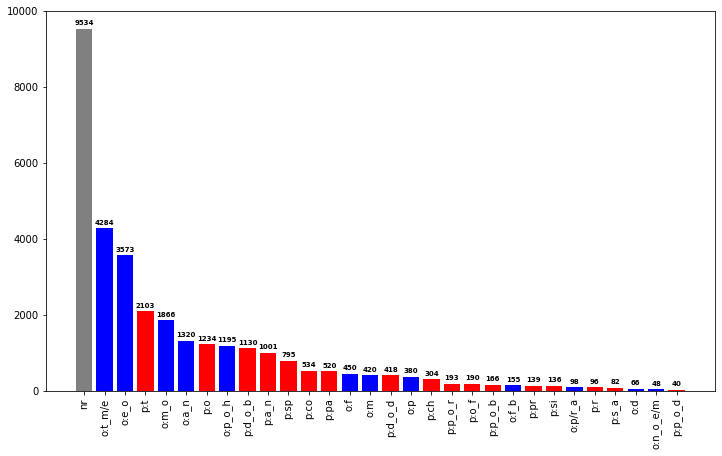

In [91]:
import matplotlib.pyplot as plt

name2nick = {}
for tld in train_labels_dict.items():
    name2nick[tld[0]] = label2nick[tld[1]]

train_labels_num_dict = defaultdict(int)
for train_label in train_data.label:
    train_labels_num_dict[name2nick[train_label]] += 1
    
tlnd4plt_sorted = sorted(train_labels_num_dict.items(), reverse=True, key=lambda x: x[1])
tlnd4plt_sorted_keys = [ts[0] for ts in tlnd4plt_sorted]
tlnd4plt_sorted_values = [ts[1] for ts in tlnd4plt_sorted]

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
clist = []
for tlnd in tlnd4plt_sorted_keys:
    if tlnd.startswith('o'):
        clist.append('blue')
    elif tlnd.startswith('p'):
        clist.append('red')
    else:
        clist.append('gray')
ax.bar(tlnd4plt_sorted_keys, tlnd4plt_sorted_values, color=clist)
plt.xticks(rotation='vertical')

for idx, value in enumerate(tlnd4plt_sorted_values):
    ax.text(idx, value+100, s=value, ha='center', fontweight='bold', fontsize=7)
    
plt.show()

In [92]:
train_data = augmented_data

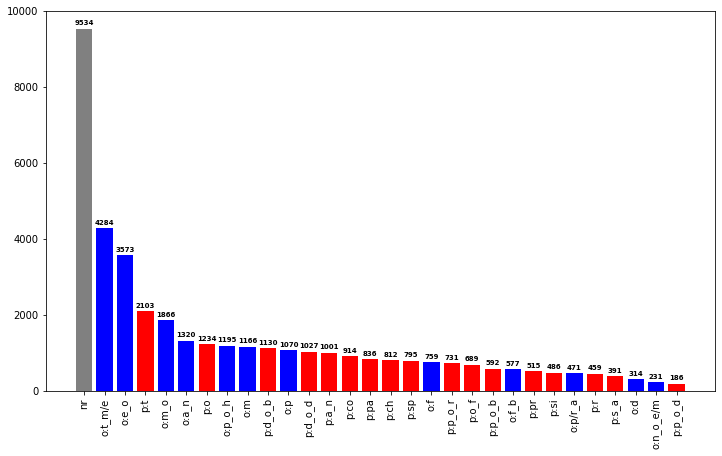

In [93]:
import matplotlib.pyplot as plt

name2nick = {}
for tld in train_labels_dict.items():
    name2nick[tld[0]] = label2nick[tld[1]]

train_labels_num_dict = defaultdict(int)
for train_label in train_data.label:
    train_labels_num_dict[name2nick[train_label]] += 1
    
tlnd4plt_sorted = sorted(train_labels_num_dict.items(), reverse=True, key=lambda x: x[1])
tlnd4plt_sorted_keys = [ts[0] for ts in tlnd4plt_sorted]
tlnd4plt_sorted_values = [ts[1] for ts in tlnd4plt_sorted]

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
clist = []
for tlnd in tlnd4plt_sorted_keys:
    if tlnd.startswith('o'):
        clist.append('blue')
    elif tlnd.startswith('p'):
        clist.append('red')
    else:
        clist.append('gray')
ax.bar(tlnd4plt_sorted_keys, tlnd4plt_sorted_values, color=clist)
plt.xticks(rotation='vertical')

for idx, value in enumerate(tlnd4plt_sorted_values):
    ax.text(idx, value+100, s=value, ha='center', fontweight='bold', fontsize=7)
    
plt.show()

In [94]:
augmented_data.to_csv('~/dataset/train/train_aug_4eda_ksh.csv', index=False)

In [96]:
train_aug_data = augmented_data
label_list = train_aug_data.label.unique().tolist()
dev_aug_data = pd.DataFrame(columns=train_aug_data.columns)

for label in label_list:
    label_data = train_aug_data[train_aug_data.label == label]
    label_data = label_data.sample(frac=0.1, random_state=42)
    train_aug_data = train_aug_data.drop(label_data.index)
    dev_aug_data = pd.concat([dev_aug_data, label_data])

In [99]:
train_aug_data.to_csv('~/dataset/train/train_aug_4eda_90_ksh.csv', index=False)

In [100]:
dev_aug_data.to_csv('~/dataset/dev/dev_aug_4eda_10_ksh.csv', index=False)